# BGPDistinct
##### Analyzing BGP messages to classify them as either distinct or duplicated/propagated
*Author: Andy Dolan*

## Creating a Network for Analyzing BGP "Distinctness"
*Can we distinguish unique messages from duplicates?*

### Introduction
As previously discussed, a BGP message may be uniquely identified by its prefix, mask, and final destination AS number (hereafter referred to as the *composite key* of a message). The goal of this project is to analyze the number of such "distinct" messages over a period of time, using machine learning techniques. The timestamp of a message is also included as an input to our methods, as it may help determine whether or not a message is distinct (e.g., a message that has the same composite key from a message that is a week older are likely in regards to a different distinct event).

In [1]:
import sys
# This assumes that the BGPDistinct codebase is located in ../src
sys.path.append('../src/')

import json
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from learning import NetworkBGP
%matplotlib inline

### In Review: Data
The data to be analyzed had already been properly formatted and had relevant features extracted. In all, each representation of a BGP message contained a timestamp, the full path of the message (i.e., each AS number in the path to the final destination AS), and the composite key, consisting of the announced prefix, the prefix mask, and the final destination AS number. Only the timestamp and fields held in the composite key were used as inputs to the neural network, while the full AS path was kept as a convenience for data experimentation.

### A Note about Labeling
Note that data was only labeled upon partitioning, as different partitions neccessitate different labels for each datapoint therein. That is, labeling the data before partitioning could result in incorrectly labled inputs after partitioning. Consider the example that a message that is a duplicate of only one other message that came before it is moved to the test partition, and no duplicate message precedes it, and the message should therefore be considered distinct.

A naive labeling scheme was chosen for the purposes of this project, due to time constraints and realistic need of more complex labeling. Specifically, the labeling scheme did not take temporal difference into account. For the datasets used during training, this likely did not have a great impact, as time periods spanned a minute, at most. Still, labeling remains one of the biggest challenges to be addressed in future work.

In [2]:
with open('../data/extracted_one_min_nov15.json') as f:
    full = json.load(f)
full[:3]

[{'time': 1542313320,
  'composite': {'prefix': '2620:0:2f0::', 'mask': 48, 'dest': 32629},
  'full_path': [63956, 4637, 174, 32629]},
 {'time': 1542313320,
  'composite': {'prefix': '2a0b:d080::', 'mask': 32, 'dest': 205747},
  'full_path': [63956, 13030, 60804, 174, 6830, 205747]},
 {'time': 1542313320,
  'composite': {'prefix': '94.185.102.0', 'mask': 24, 'dest': 198013},
  'full_path': [2914, 3356, 3549, 5392, 5392, 198013]}]

Note the elements in the example above that will be used as inputs to the network, those being the timestamp, the prefix, the mask, and the final destination AS number. These elements are converted to numeric representations and rescaled appropriately during partitioning.

## Creating a Network
The network utilized for distinguishing distinct BGP messages was relatively simple, but maintained a surprisingly high accuracy when classifying data. The network consisted of three linear layers, each paired with a ReLU activation function, followed by a final linear layer paired with the LogSoftmax function (for use with the NLLLoss loss funciton).

The hidden layers in the network also consist of a large number of neurons, to extrapolate on the relationships between input features.

In [3]:
net_manager = NetworkBGP(full, 10, lr=0.01, cw=[0.08, 1])

There are 8768 messages to be labeled
There are 2191 messages to be labeled


In [4]:
net_manager.Xtrain[:3]

tensor([[-1.6574,  2.5865,  1.3402, -0.4341],
        [-1.6574, -0.3951, -0.2157,  1.3723],
        [-1.6574, -0.3971, -0.2157, -0.6919]], dtype=torch.float64)

In [5]:
net_manager.net

DistinctNN(
  (h1): Linear(in_features=4, out_features=10, bias=True)
  (a1): ReLU()
  (h2): Linear(in_features=10, out_features=10, bias=True)
  (a2): ReLU()
  (h3): Linear(in_features=10, out_features=10, bias=True)
  (a3): ReLU()
  (raw_out): Linear(in_features=10, out_features=2, bias=True)
  (out_act): LogSoftmax()
)

## Training the Network

In [6]:
start = time.time()
losses = net_manager.train_network(num_iterations=1000)
print('Training took {}'.format(time.time() - start))

Training took 3.5642378330230713


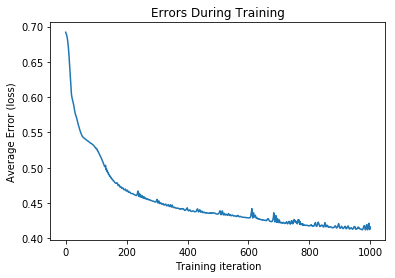

In [7]:
plt.plot(losses)
plt.ylabel('Average Error (loss)')
plt.xlabel('Training iteration')
plt.title('Errors During Training')
plt.show()

In [8]:
losses[-1]

[array(0.4160657)]

## Testing the Network
### Data used for Training

In [9]:
alpha=0.1

In [10]:
predicted = torch.max(net_manager.net(net_manager.Xtrain), 1)[1].numpy()
actual = net_manager.Ttrain.numpy().flatten()

In [11]:
predicted

array([1, 1, 1, ..., 0, 0, 1])

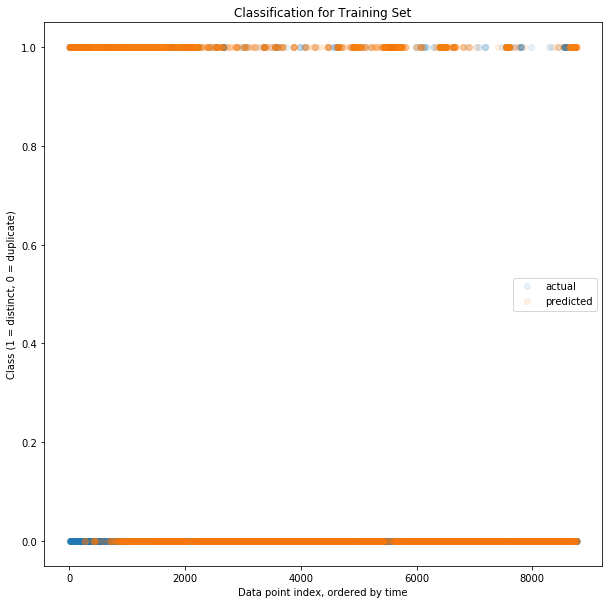

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Training Set')
plt.show()

In [13]:
net_manager.get_correct(predicted, actual)

(0.8023494525547445, 0.8008458763527802, 0.8189300411522634)

In [14]:
total_correct, duplicate_correct, distinct_correct = net_manager.get_correct(predicted, actual)
print('% of total correctly classified: {:.2%}'.format(total_correct))
print('% of duplicate messages correctly classified: {:.2%}'.format(duplicate_correct))
print('% of distinct messages correctly classified distinct: {:.2%}'.format(distinct_correct))

% of total correctly classified: 80.23%
% of duplicate messages correctly classified: 80.08%
% of distinct messages correctly classified distinct: 81.89%


### On New Data

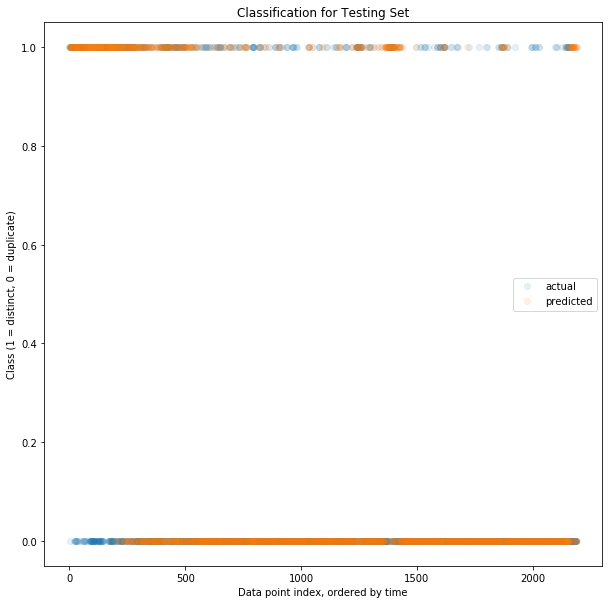

In [15]:
predicted = net_manager.get_predicted_classes(net_manager.net(net_manager.Xtest))
actual = net_manager.Ttest.numpy().flatten()
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.plot(actual, 'o', alpha=alpha, label='actual')
ax.plot(predicted, 'o', alpha=alpha, label='predicted')
plt.legend()
plt.ylabel('Class (1 = distinct, 0 = duplicate)')
plt.xlabel('Data point index, ordered by time')
plt.title('Classification for Testing Set')
plt.show()

In [16]:
total_correct, duplicate_correct, distinct_correct = net_manager.get_correct(predicted, actual)
print('% of total correctly classified: {:.2%}'.format(total_correct))
print('% of duplicate messages correctly classified: {:.2%}'.format(duplicate_correct))
print('% of distinct messages correctly classified distinct: {:.2%}'.format(distinct_correct))

% of total correctly classified: 79.96%
% of duplicate messages correctly classified: 84.76%
% of distinct messages correctly classified distinct: 59.67%
